In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy import signal
from IPython.display import clear_output

Импорт сигнала из файла.

In [17]:
x = np.genfromtxt('signal.txt')
len(x)

1000

"Вручную" обрезаем спектр сигнала в окрестности основного пика.

<function matplotlib.pyplot.show(close=None, block=None)>

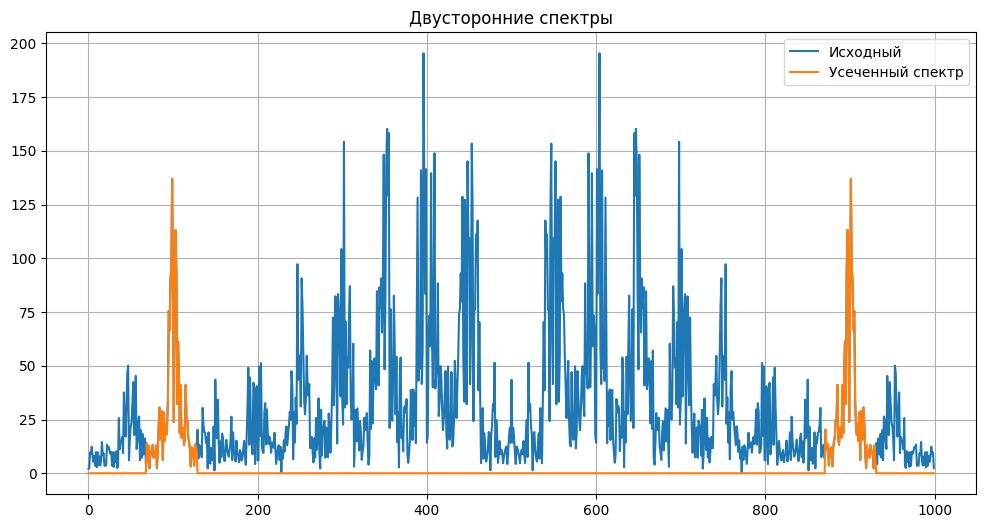

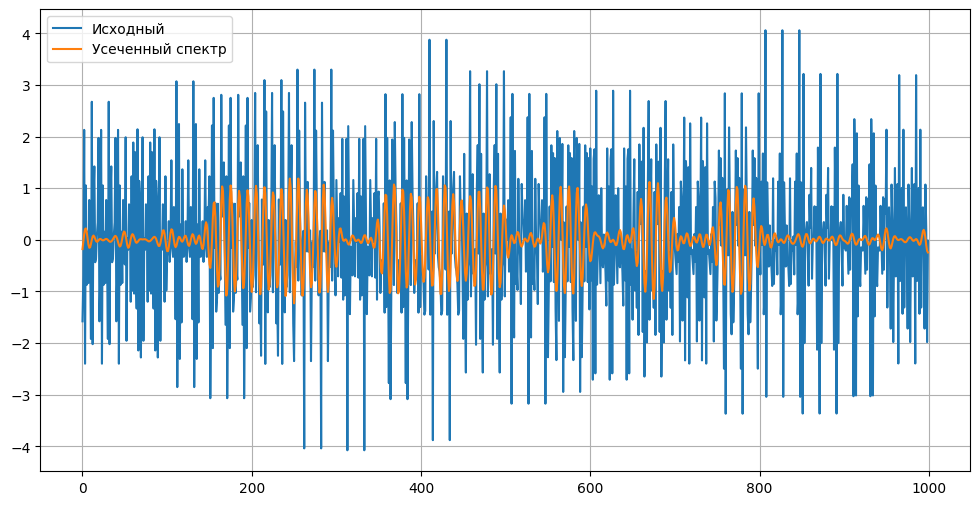

In [18]:
user_figsize = (12, 6)
plot_names_wave = 'Исходный', 'Усеченный спектр'
plot_names = 'Исходный', 'После фильтрации'

Nfft = len(x)
delta_f = 60
f_center = 100 - 1
X = np.fft.fft(x)
# Усечение спектров.
X_cut = X.copy()
X_cut[:(f_center - delta_f//2) ] = np.zeros(len(X_cut[:(f_center - delta_f//2) ]))
X_cut[-(f_center - delta_f//2):] = np.zeros(len(X_cut[-(f_center - delta_f//2):]))
X_cut[(f_center + delta_f//2):-(f_center + delta_f//2)] = np.zeros(len(X_cut[(f_center + delta_f//2):-(f_center + delta_f//2)]))

plt.figure(figsize=user_figsize)
plt.plot(np.abs(X))
plt.plot(np.abs(X_cut))
plt.grid()
plt.title('Двусторонние спектры')
plt.legend(plot_names_wave)
plt.savefig('readme_img/spectrum_cut.png', bbox_inches='tight')
plt.show

x_cut = np.real(np.fft.ifft(X_cut))
plt.figure(figsize=user_figsize)
plt.plot(x)
plt.plot(x_cut)
plt.grid()
plt.legend(plot_names_wave)
plt.savefig('readme_img/signals_cut.png', bbox_inches='tight')
plt.show

Сигнал принимает вещественные значения. Поэтому, в спектре достаточно ограничиться половиной массива. В дальнейших расчетах достаточно ограничиться амплитудным спектром.

In [19]:
Xfft = np.abs(    X[:Nfft//2])
Zfft = np.abs(X_cut[:Nfft//2])

Оптимальные значения коэффициентов фильтра определим путем минимизации функции потерь формальными методами. В качестве функции потерь принята сумма квадратов отклонений спектров исходного сигнала и эталонного спектра. В качестве эталонного принят усеченный спектр.

In [20]:
# X - амплитудный спектр сигнала.
# y - эталон амплитудного спектра.
def loss_func(X, y, w_coeff):
    a2 = w_coeff[0,0]
    w0 = w_coeff[0,1]
    # Коэффициенты фильтра.
    b = [(1-a2)/2, 0, -(1-a2)/2]
    a = [1, -(1+a2)*np.cos(w0), a2]
    # Частотная характеристика фильтра.
    _, h = signal.freqz(b, a, worN=len(X))
    # Амплитудный спектр сигнала на выходе фильтра.
    Yfft = np.abs(h)*X
    # Функция возвращает сумму квадратов отклонений эталонного спектра от вычисленного.
    return np.sum((y - Yfft)**2)

Алгоритм градиентного спуска.

In [21]:
def model_fit(X_train, y_train, learning_rate, delta_tolerance):

    iteration_max = 200000
    
    # Инициализируем коэффициенты [a2, w0].
    w_coeff = np.array([[0.5, 0.5]])
    
    # Полный буфер коэффициентов.
    w_coeff_buff = w_coeff.copy()

    # Градиенты инициализируются ненулевыми значениями.
    grad = np.ones_like(w_coeff)
    
    losses = []
        
    for i in range(iteration_max):
        # Элемент оптимизации: ошибку при начальных коэффициентах считаем 1 раз.
        loss_init = loss_func(X_train, y_train, w_coeff)
        for k, w in enumerate(w_coeff.tolist()[0]):

            # Шаг градиентного спуска на основе значений градиента, вычисленных на предыдущем шаге.
            w_step = - learning_rate * grad[0,k]

            # Сбрасываем все коэффициенты до исходный значений текущей итерации.
            w_coeff_1 = w_coeff.copy()
            w_coeff_2 = w_coeff.copy()
            
            # Модификация только k-го коэффициента:
            w_coeff_1[0,k] = w + w_step
            w_coeff_2[0,k] = w + 2*w_step

            # Формируем массив значений функции потерь, для вычисления градиента. Массив состоит из 3х элементов.
            loss_func_grad = [loss_init,
                              loss_func(X_train, y_train, w_coeff_1),
                              loss_func(X_train, y_train, w_coeff_2)]
            
            # Массив градиента состоит из 3х чисел с индексами [0, 1, 2]. Берем предпоследнее число.
            grad[0,k] = np.gradient(loss_func_grad, w_step)[1]
            
            # Обновление одного коэффициента в итоговом массиве.
            w_coeff_buff[0,k] = w_coeff_1[0,k].copy()
                
        # Обновление всех коэффициентов.
        w_coeff = w_coeff_buff.copy()
        
        # Вычисление ошибки на полном датасете, при обновленных коэффициентах.
        loss = loss_func(X_train, y_train, w_coeff)

        # Накопление ошибки в отдельный массив для дальнейшей визуализации.
        losses.append(loss)

        if i % 1000 == 0:
            clear_output(wait=True)
            print('Iteration:', i)
            print('Gradient:', np.round(grad[0],4))
            print('Weights:', np.round(w_coeff[0],4))
            print('Loss:', np.round(loss,4))
        if i > 2:
            if ((losses[-2] - losses[-1]) < delta_tolerance):
                break
    
    return w_coeff, losses

Минимизация функции потерь.

In [22]:
weights, losses = model_fit(Xfft, Zfft, learning_rate=1e-9, delta_tolerance=1e-9)

Iteration: 12000
Gradient: [-1.0035 -0.0798]
Weights: [0.8787 0.6284]
Loss: 5751.0618


<function matplotlib.pyplot.show(close=None, block=None)>

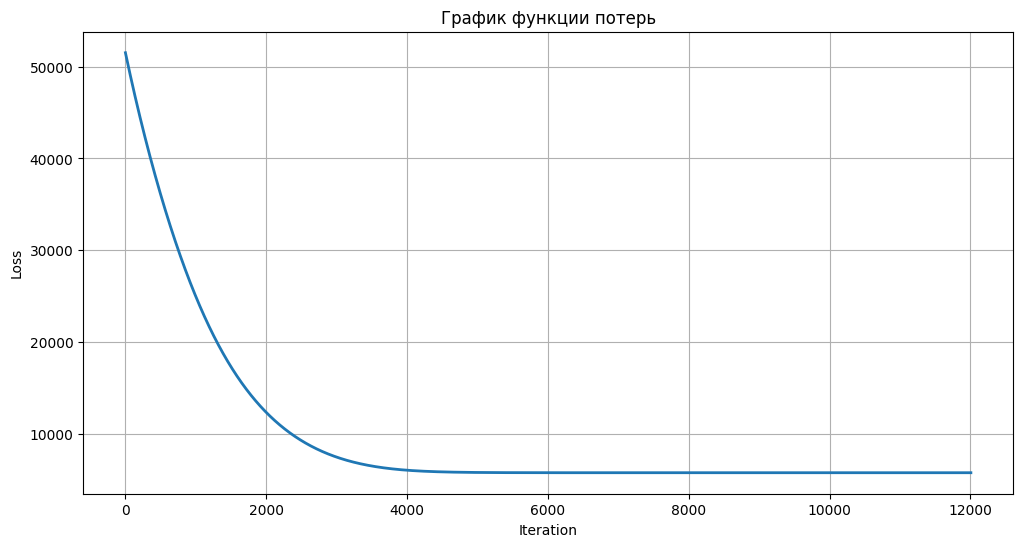

In [23]:
plt.figure(figsize=user_figsize)
plt.plot(losses, linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('График функции потерь')
plt.grid()
plt.show

In [24]:
print('Оптимальные значения коэффициентов:')
w0 = weights[0,1]
a2 = weights[0,0]
print('w0=' + str(np.round(w0, 4)))
print('a2=' + str(np.round(a2, 4)))

Оптимальные значения коэффициентов:
w0=0.6284
a2=0.8787


Частотная характеристика фильтра при оптимальных значениях коэффициентов.

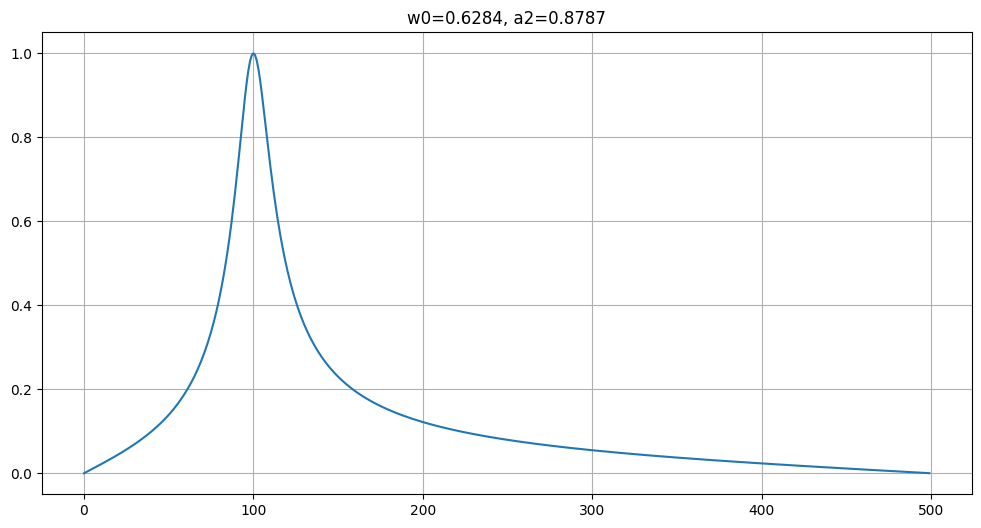

In [25]:
b = [(1-a2)/2, 0, -(1-a2)/2]
a = [1, -(1+a2)*np.cos(w0), a2]

_, h = signal.freqz(b, a, worN=Nfft//2)

plt.figure(figsize=user_figsize)
plt.plot(np.abs(h))
plt.title('w0=' + str(np.round(w0, 4)) + ', a2=' + str(np.round(a2, 4)))
plt.grid()
plt.savefig('readme_img/filter_freq_resp.png', bbox_inches='tight')
plt.show()

Реализация фильтра в виде разностных уравнений.

In [26]:
def IIR_filter(x, b_coeff, a_coeff):
    # Создаем список из нулей.
    y = [0] * len(x)
    for k in range(len(x)):
        for m, b in enumerate(b_coeff):
            if (k-m) >= 0:
                y[k] += b * x[k-m]
        for n, a in enumerate(a_coeff[1:], start=1):
            if (k-n) >= 0:
                y[k] -= a * y[k-n]
    return y

Фильтрация сигнала с помощью фильтра при найденных оптимальных параметрах.

<function matplotlib.pyplot.show(close=None, block=None)>

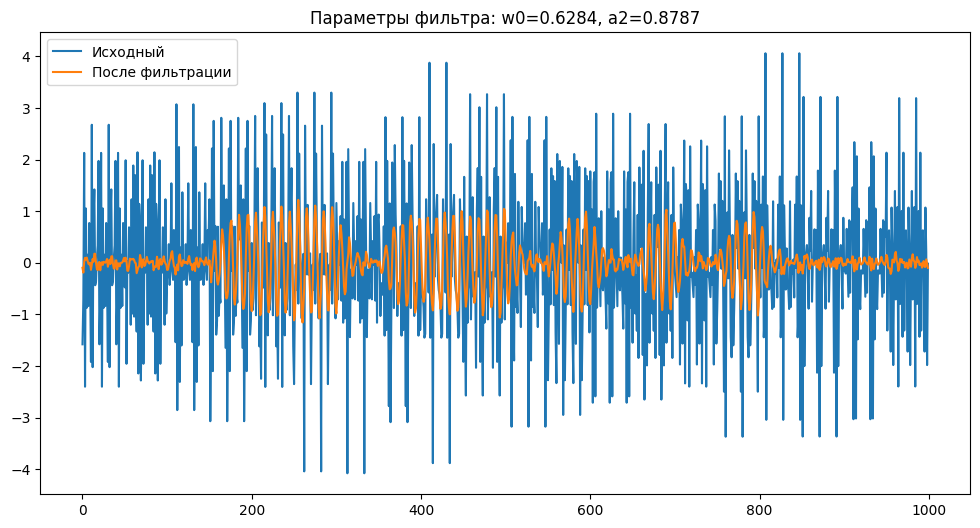

In [27]:
y = IIR_filter(x, b, a)

plt.figure(figsize=user_figsize)
plt.plot(x)
plt.plot(y)
plt.title('Параметры фильтра: w0=' + str(np.round(w0, 4)) + ', a2=' + str(np.round(a2, 4)))
plt.legend(plot_names)
plt.savefig('readme_img/signal_filtered.png', bbox_inches='tight')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

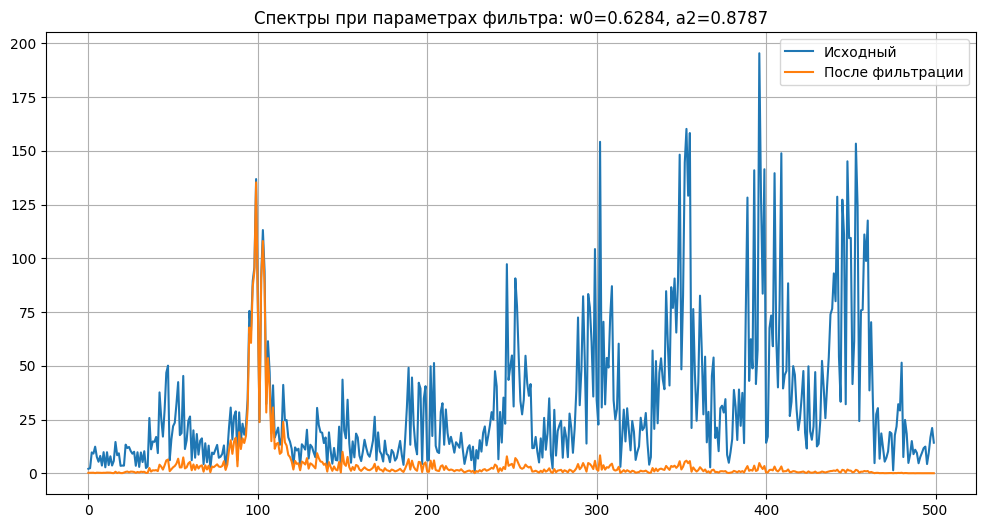

In [28]:
Yfft = np.abs(np.fft.fft(y)[:Nfft//2])

plt.figure(figsize=user_figsize)
plt.plot(Xfft)
plt.plot(Yfft)
plt.title('Спектры при параметрах фильтра: w0=' + str(np.round(w0, 4)) + ', a2=' + str(np.round(a2, 4)))
plt.legend(plot_names)
plt.grid()
plt.savefig('readme_img/spectrum_filtered.png', bbox_inches='tight')
plt.show

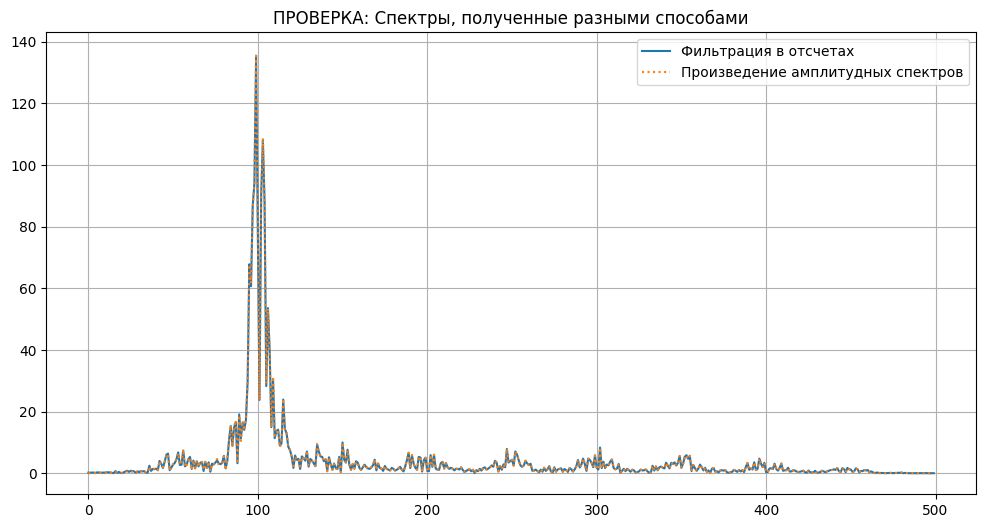

In [29]:
plt.figure(figsize=user_figsize)
plt.plot(Yfft)
plt.plot(np.abs(h)*Xfft, ':')
plt.title('ПРОВЕРКА: Спектры, полученные разными способами')
plt.legend(['Фильтрация в отсчетах', 'Произведение амплитудных спектров'])
plt.grid()
plt.show()